# Anthropogenic heat from human metabolism

This notebook is used to process population data, and ultimately produce the anthropogenic heat flux (AHF) from human metabolism for the Greater Los Angeles (LA) region.

In [1]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
#import requests
import geopandas as gpd
import pyproj
import shapely.geometry
import contextily as ctx
from matplotlib.ticker import FormatStrFormatter
import geofeather
import dask_geopandas as dgpd
import pyogrio
import folium
import numpy as np

In [148]:
# define paths to data
acs_folder = Path('/Users/josephko/USC/Research/Anthropogenic Heat/census/acs')
ctpp_folder = Path('/Users/josephko/USC/Research/Anthropogenic Heat/census/ctpp')
bounds_folder = Path('/Users/josephko/USC/Research/Anthropogenic Heat/boundaries')

In [221]:
# import Census-based ACS data and CTPP data
"""
ACS = american community survey
CTPP = census transportation planning products program
- CTPP data is derived from ACS data
- 5-yr data (2012-2016) is used
- all data below is aggregated to census tract
"""
# import total population (from ACS table B01003)
total_pop_path = acs_folder / 'ACSDT5Y2016.B01003_2022-04-18T013603' / 'ACSDT5Y2016.B01003_data_clean.csv'
total_pop = pd.read_csv(total_pop_path)

# import total workers living in area (from ACS table B08008)
total_workers_living_path = acs_folder / 'ACSDT5Y2016.B08008_2022-04-18T115010' / 'ACSDT5Y2016.B08008_data_clean.csv'
total_workers_living = pd.read_csv(total_workers_living_path)

# import total workers working in area (from CTPP)
total_workers_working_path = ctpp_folder / 'total_workers_lacounty_tract.csv'
total_workers_working = pd.read_csv(total_workers_working_path, dtype = 'string')

# import california census tracts shapefile
tract_bounds_path = bounds_folder / 'ca_2016_census_tracts.zip'
tract_bounds = gpd.read_file(tract_bounds_path)

In [222]:
# remove catalina island and avalon from census tracts
tract_bounds.drop(tract_bounds.loc[(tract_bounds.NAME == '5990') | (tract_bounds.NAME == '5991')].index, inplace=True)

In [223]:
# convert to appropriate data types

# first get rid of commas and convert to float
total_workers_working['Estimate'] = total_workers_working['Estimate'].str.replace(',', '').astype(float)
total_workers_working['Margin of Error'] = total_workers_working['Margin of Error'].str.replace(',', '').astype(float)

# # then convert to int
# total_workers_working['Estimate'] = total_workers_working['Estimate'].astype('Int64')
# total_workers_working['Margin of Error'] = total_workers_working['Margin of Error'].astype('Int64')

In [224]:
# rename columns of dataframes for further merging 
total_workers_working.rename(columns={'WORKPLACE':'NAME'}, inplace=True)

tract_bounds.rename(columns={'AFFGEOID':'GEO_ID'}, inplace=True)

In [225]:
# merge 'total population' with 'total workers living in area'
cols_to_use = total_workers_living.columns.difference(total_pop.columns).to_list()
cols_to_use.append('GEO_ID')
total_pop_merge_workers_living = total_pop.merge(total_workers_living[cols_to_use], on = 'GEO_ID', how = 'inner')

# continue merging with 'total workers working in area'
total_pop_workers_living_working = total_pop_merge_workers_living.merge(total_workers_working, on='NAME', how='inner')

# final merge with census tract boundaries
final_merged_gdf = tract_bounds.merge(total_pop_workers_living_working, on='GEO_ID', how='right')


In [226]:
"""
Note: The final_merged_gdf has two less records because Census tracts 9901 and 9902 are dropped. 
- these census tracts have populations of zero
- likely census tracts off the coast and therefore not included in the original CA census tracts shapefile
"""
# final_merged_gdf.shape
# final_merged_gdf[final_merged_gdf.geometry==None]
# total_pop[total_pop.GEO_ID == '1400000US06037990200']

'\nNote: The final_merged_gdf has two less records because Census tracts 9901 and 9902 are dropped. \n- these census tracts have populations of zero\n- likely census tracts off the coast and therefore not included in the original CA census tracts shapefile\n'

In [227]:
final_merged_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [228]:
# rename columns to be more readable
final_merged_gdf.rename(columns={'B01003_001E':'pop_night','Estimate':'n_workers_working', 'B08008_001E':'n_workers_living'}, inplace=True)

In [229]:
# calculate daytime adjusted population
"""
https://www.census.gov/topics/employment/commuting/guidance/calculations.html
Method 2: Total resident population + Total workers working in area - Total workers living in area
 -> 'pop_night' + 'n_workers_working' - 'n_workers_living'
"""
final_merged_gdf['pop_day'] = final_merged_gdf['pop_night'] + final_merged_gdf['n_workers_working'] - final_merged_gdf['n_workers_living']

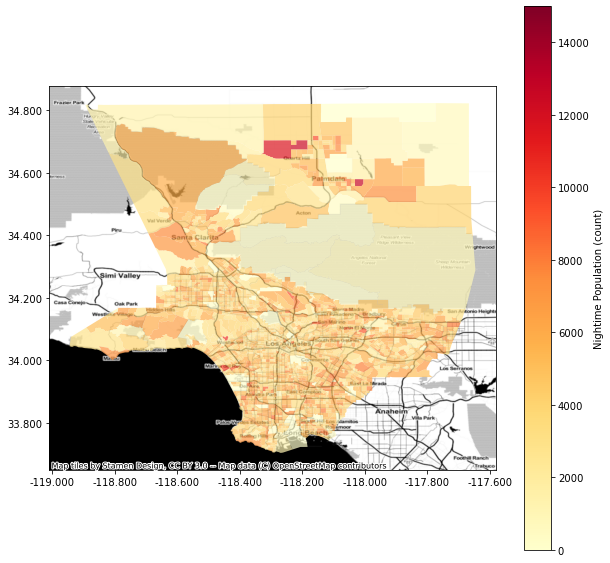

In [230]:
# map night-time (residential) population 
ax = final_merged_gdf.plot(figsize=(10,10), column='pop_night', alpha=0.7, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 15000,
                           legend_kwds={'label':'Nightime Population (count)'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

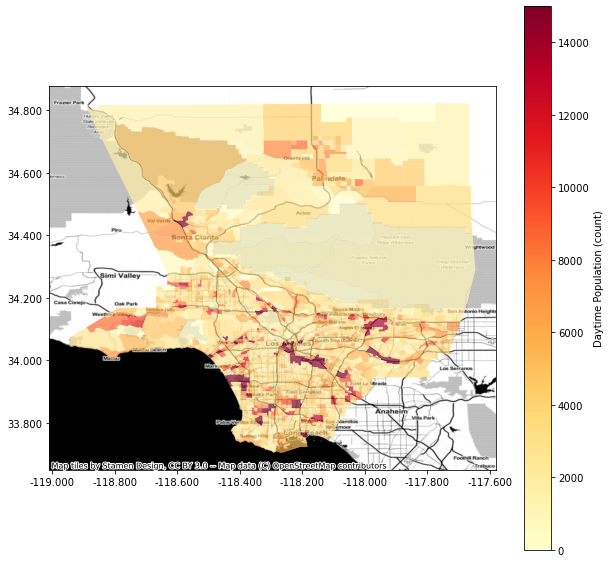

In [231]:
# map daytime-time (commute-adjusted) population 
ax = final_merged_gdf.plot(figsize=(10,10), column='pop_day', alpha=0.7, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 15000,
                           legend_kwds={'label':'Daytime Population (count)'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [233]:
# calculate population densities (day and night)
final_merged_gdf['area'] = final_merged_gdf.geometry.to_crs('EPSG:3310').area
final_merged_gdf['pop_density_night'] = (final_merged_gdf['pop_night']/final_merged_gdf['area'])*(10**6)
final_merged_gdf['pop_density_day'] = (final_merged_gdf['pop_day']/final_merged_gdf['area'])*(10**6)

# calculate weighted pop density
final_merged_gdf['pop_density_night_weighted'] = (final_merged_gdf['area']*final_merged_gdf['pop_density_night'])/(final_merged_gdf['area'].sum())
final_merged_gdf['pop_density_day_weighted'] = (final_merged_gdf['area']*final_merged_gdf['pop_density_day'])/(final_merged_gdf['area'].sum())

In [234]:
# total population density of LA county (not including catalina island and avalon)
final_merged_gdf['pop_density_night_weighted'].sum()

978.4155970993215

In [257]:
# check that the sum day and night populations match
sum_pop_day = final_merged_gdf['pop_day'].sum()
sum_pop_night = final_merged_gdf['pop_night'].sum()
print('Daytime population = ', sum_pop_day)
print('Nighttime population = ', sum_pop_night)

Daytime population =  8996735.0
Nighttime population =  10057155


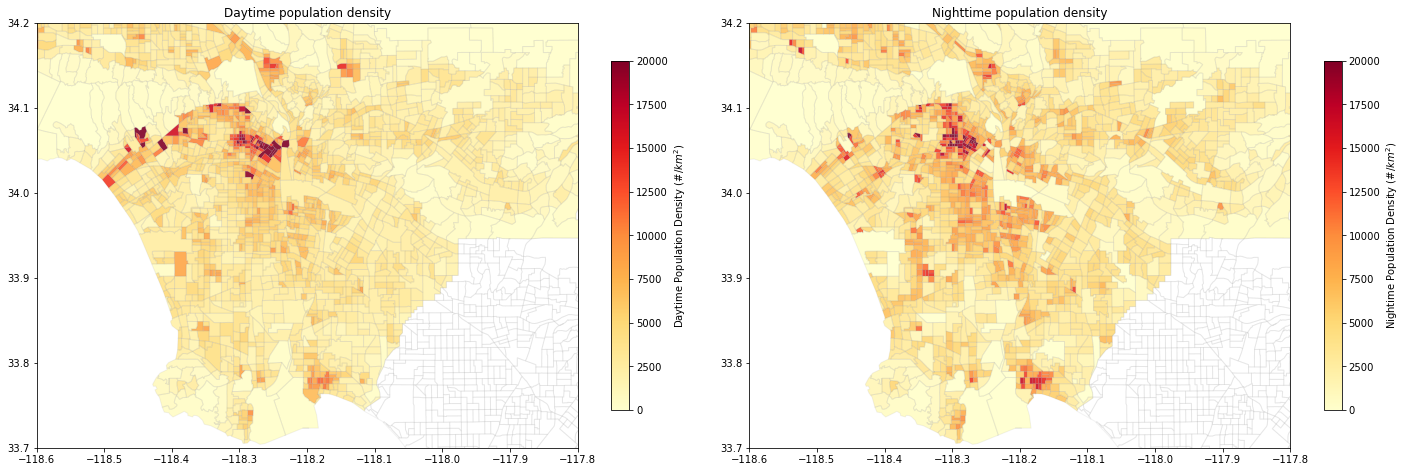

In [255]:
# plot population densities (day and night)
fig, axes = plt.subplots(figsize=(20, 10), ncols=2, nrows=1)
final_merged_gdf.plot(ax=axes[0], column='pop_density_day', alpha=0.9, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 20000,
                           legend_kwds={'label':'Daytime Population Density (#/$km^2$)',
                                       'shrink':0.5})
tract_bounds.plot(ax=axes[0], figsize=(10,10), alpha=0.1, facecolor = 'none', edgecolor='gray')
#ctx.add_basemap(axes[0], source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
final_merged_gdf.plot(ax=axes[1], column='pop_density_night', alpha=0.9, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 20000,
                           legend_kwds={'label':'Nightime Population Density (#/$km^2$)',
                                       'shrink':0.5})
tract_bounds.plot(ax=axes[1], figsize=(10,10), alpha=0.1, facecolor = 'none', edgecolor='gray')
#ctx.add_basemap(axes[1], source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
axes[0].set_title("Daytime population density")
axes[1].set_title("Nighttime population density")
axes[0].set_xlim(-118.6, -117.8)
axes[0].set_ylim(33.7, 34.2)
axes[1].set_xlim(-118.6, -117.8)
axes[1].set_ylim(33.7, 34.2)
fig.tight_layout()

In [ ]:
"""
https://www.census.gov/topics/employment/commuting/guidance/calculations.html
"""